Math 532H: NONLINEAR DYNAMICS 
<br />
Instructor: Professor Markos Katsoulakis
<br />
Final Project Write-up 2
<br />
Sheikh Saqlain, Lisa Zhao

# <center> Learning Non-Linear Dynamics: SIR Model </center> 


### 1. Introduction

In this project, we want to apply deep learning to solve the inverse problem in the case of epidemic model. More specifically, we aim to use real COVID data to learn parameters in a epidemic model. In this second write-up, we experimented with the classic SIR epidemic model. We did the inverse problem based on data generated from a self-defined SIR model using a python solver. DeepXDE, a deep learning library was used to discover all parameters. At the end, we compared its results with our pre-defined model. 

### 2. A Classic SIR Model
$$\begin{equation}
\left\{ 
  \begin{aligned}
    \frac{dS}{dt} &=& &-\beta IS/N,& &S(0) = S_0 \ge 0&\\
    \frac{dI}{dt} &=& &\beta IS/N - \gamma I,&&I(0) = I_0 \ge 0&\\
    \frac{dR}{dt} &=& &\gamma I,& &R(0) = R_0 \ge 0&\\
  \end{aligned}
  \right.
\end{equation}
$$

The SIR model aims to predict the number of individuals who are susceptible to infection, are actively infected, or have recovered from infection at any given time.

Three state variables are $S(t)$, $I(t)$, and $R(t)$. $S(t)$ is the number of susceptibles at time $t$, $I(t)$ is the number of infectives, $R(t)$ is the number of recovered people with immunity. Since $N$ is the total population size, $S/N$ is the susceptible fractions and $S + I+R = N$. Two parameters are $\beta > 0$ and $\gamma>0$. $\beta$ is the contact rate and $ \gamma$ is the rate of recovery.


The term $\beta IS/N$ indicates that new infections occur as a result of contact between infectives and susceptibles.
When a new infection occurs, the individual infected moves from the susceptible class to the infective class. The term $\gamma I$ indicates that infections get recovered in the rate of $\gamma$. When a person recover from infection, the individual removes from the infective class and add to the recovery class. The total population $S+I+R$ is a constant since $\frac{dS}{dt}+\frac{dI}{dt}+\frac{dR}{dt} = 0$

Below is just an initial exploration of the model where we find the solutions S,I,R as functions to t. In next section, we will use different parameters and initial condition to create training set for the deep learning algorithm. 

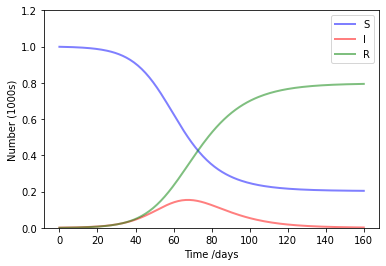

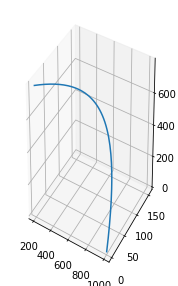

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial condition
I0, R0 = 1, 0
S0 = N - I0 - R0
y0 = S0, I0, R0
# parameters
beta, gamma = 0.2, 1./10 
# time points in days
t = np.linspace(0, 160, 160)

# The SIR model
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Integrate the SIR equations over the time grid, t.
sol = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='S')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='I')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='R')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
legend = ax.legend()
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(S,I,R)
plt.show()

### 3. Deep Learning Using DeepXDE

In [2]:
!pip install deepxde 

     |████████████████████████████████| 111 kB 4.4 MB/s 
     |████████████████████████████████| 100 kB 8.1 MB/s 


In [3]:
# All the imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import requests

import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf
import random

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



#### 3.1 Build Model and Generate Training data

This part of the notebook contains the data generation functions. We simply use a numerical integrator to generate data for a set of given initail conditions and parameters.

In [4]:
def SIRmodel(S, I, R):
  beta = 3
  gamma = 1
  N = S + I + R
  return (-beta*I*S/N), ((beta*I*S/N) - gamma*I), (gamma*I)

def SIRmodel_(t, z):
  S, I, R = z
  return SIRmodel(S, I, R)

def gen_traindata():
  dt = 0.01
  tn = 20

  S0 = 10 
  I0 = 1 
  R0 = 0 
  
  sol = scipy.integrate.solve_ivp(SIRmodel_, (0, tn), (S0, I0, R0), method = 'RK45', t_eval = np.arange(0, tn, dt))

  return np.row_stack(np.array(sol.t)), np.column_stack((np.array(sol.y[0]), np.array(sol.y[1]), np.array(sol.y[2])))

In [5]:
# Initialize the parameters we are trying to find
beta = tf.Variable(0.0)
gamma = tf.Variable(0.0)

# Define the function that returns the system residuals
def SIRmodel__(t, y):
  S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:]
  dS_t = dde.grad.jacobian(y, t, i = 0)
  dI_t = dde.grad.jacobian(y, t, i = 1)
  dR_t = dde.grad.jacobian(y, t, i = 2)
  N = S + I + R + 10**-6 # The last term is a regularization term to deal with the case where S + I + R = 0
  return [
          (-beta*I*S/N) - dS_t,
          ((beta*I*S/N) - gamma*I) - dI_t,
          (gamma*I) - dR_t 
          ]

# A function that returns the boundary conditions
def boundary(_, on_initial):
    return on_initial

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  total_n_samples))


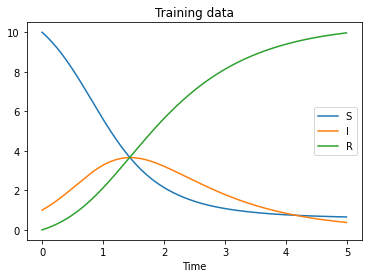

In [6]:
# define time domain
geom = dde.geometry.TimeDomain(0, 5)


# Initial conditions
ic1 = dde.IC(geom, lambda X: 10, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 1, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 0, boundary, component=2)


# Get the training data
obs_t, obs_y = gen_traindata()
observe_t = obs_t[0:500]
ob_y = obs_y[0:500, :]
observe_S = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_I = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_R = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)


# define data object
data = dde.data.PDE(
    geom,
    SIRmodel__,
    [ic1, ic2, ic3, observe_S, observe_I, observe_R],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

# Plot the initial data
plt.plot(observe_t, ob_y)
plt.xlabel('Time')
plt.legend(['S','I','R'])
plt.title('Training data')
plt.show()

#### 3.2 Learning Parameters from Data.

Most of the code is similar to an example from the DeepXDE documentation (https://deepxde.readthedocs.io/en/latest/demos/lorenz.inverse.html). Our intention has been to use the same framework that they used but to solve a different problem.

In [7]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [beta, gamma], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = model.train(epochs=10000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.090265 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.140770 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.94e-03, 5.36e-02, 1.90e-03, 1.00e+02, 1.00e+00, 0.00e+00, 1.71e+01, 7.98e+00, 4.75e+01]    [1.94e-03, 5.36e-02, 1.90e-03, 1.00e+02, 1.00e+00, 0.00e+00, 1.71e+01, 7.98e+00, 4.75e+01]    []  
1000      [1.18e+00, 6.30e-01, 3.48e-01, 8.69e-02, 1.80e-01, 1.20e-03, 3.74e-01, 8.20e-02, 7.49e-02]    [1.18e+00, 6.30e-01, 3.48e-01, 8.69e-02, 1.80e-01, 1.20e-03, 3.74e-01, 8.20e-02, 7.49e-02]    []  
2000      [2.77e-01, 2.21e-01, 8.36e-02, 1.65e-02, 8.45e-02, 2.81e-04, 1.35e-01, 5.75e-02, 2.42e-02]    [2.77e-01, 2.21e-01, 8.36e-02, 1.65e-02, 8.45e-02, 2.81e-04, 1.35e-01, 5.75e-02, 2.42e-02]    []  
3000      [5.97e-02, 6.07e-02, 1.90e-02, 2.97e-03, 2.72e-02, 3.37e-04, 3.71e-02, 2.28e-02, 6.44e-03]    [5.97

#### 3.4 Result From Deep Learning

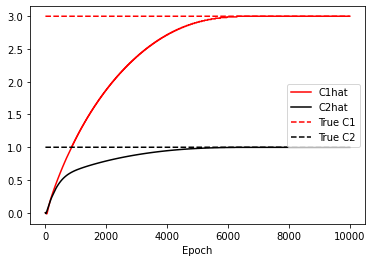

In [8]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

C1true = 3
C2true = 1


plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.legend(['C1hat','C2hat','True C1','True C2'],loc = "right")
plt.xlabel('Epoch')
plt.show()

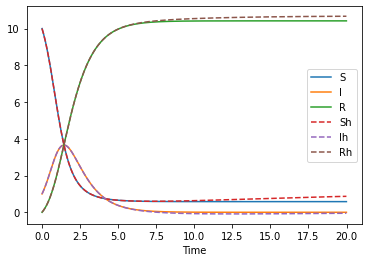

In [11]:
yhat = model.predict(obs_t)

plt.plot(obs_t, obs_y,'-',obs_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['S','I','R','Sh','Ih','Rh'])
 # plt.title('A Comparision')
plt.show()

The two plots show that the prediction fits the observation from the data, indicating that the deep learning algorithm works perfectly in solving inverse problem for our classic SIR model.

### 4. Further Explorations

#### 4.1 Different Training Data
For further study, we may want to experiment with different training data, for example, change initial conditions and parameters and increase the period of time.

#### 4.2 Different Parameters for the Deep Learning Algorithm
We can also validate with different parameters for the deep learning algorithm, such as the learning rate, the number of layers and neurons, etc.

#### 4.3 More Complicated Epidemic Model and Real Data

The algorithm learns the simple SIR model sucessfully, but what would happen if we apply the same algorithm to more complicated models with higher dimensions and more parameters? Additionally, instead of learning from self-generated data, we can also test our model in real data from COVID-19 pandemic.

#5. References

Reference: Kermack William Ogilvy and McKendrick A. G. 1927A contribution to the mathematical theory of epidemicsProc. R. Soc. Lond. A115: 700–721 http://doi.org/10.1098/rspa.1927.0118

Fokas AS, Dikaios N, Kastis
GA. 2020 Mathematical models and deep
learning for predicting the number of
individuals reported to be infected with SARSCoV-2. J. R. Soc. Interface 17: 20200494.
http://dx.doi.org/10.1098/rsif.2020.0494

Cuevas-Maraver J, Kevrekidis PG, Chen QY, Kevrekidis GA, Villalobos-Daniel V, Rapti Z, Drossinos Y. Lockdown measures and their impact on single- and two-age-structured epidemic model for the COVID-19 outbreak in Mexico. Math Biosci. 2021 Jun;336:108590. doi: 10.1016/j.mbs.2021.108590. Epub 2021 Mar 27. PMID: 33785291; PMCID: PMC7997978
